# Lecture 6: A Typical Data Science Workflow

# Setup

In [1]:
import os, sys
import tarfile
from six.moves import urllib
import hashlib

import numpy as np
import pandas as pd
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import scale
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

#import tflearn
#import tensorflow as tf

#import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# to make this notebook's output stable across runs
np.random.seed(42)

In [2]:
# Where to save the figures
# PROJECT_ROOT_DIR = "."

# def save_fig(fig_id, tight_layout=True):
#     path = os.path.join(PROJECT_ROOT_DIR, fig_id + ".png")
#     print("Saving figure", fig_id)
#     if tight_layout:
#         plt.tight_layout()
#     plt.savefig(path, format='png', dpi=300)

In [3]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")


# def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    
#     if not os.path.isdir(housing_path):
#         os.makedirs(housing_path)
        
#     tgz_path = os.path.join(housing_path, "housing.tgz")
#     if not os.path.isfile(tgz_path): #download data if not already there
#         urllib.request.urlretrieve(housing_url, tgz_path)
        
#     housing_tgz = tarfile.open(tgz_path)
#     housing_tgz.extractall(path=housing_path)
#     housing_tgz.close()

In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# Model Comparisons

## Get Data

In [5]:
def cat_data(housing, cat_by="ocean_proximity", cat_out='ocean_prox'):
    '''
    # Categorical data
    encoder = LabelEncoder()
    housing_cat = housing2[cat_by]
    housing_cat_encoded = encoder.fit_transform(housing_cat)
    housing_cat_encoded
    housing2[cat_out] = housing_cat_encoded
    '''
    #['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']
    #0    240084.285464
    #1    124805.392001
    #2    380440.000000
    #3    259212.311790
    #4    249433.977427

    housing['ocean_prox'] = 0  # INLAND
    housing.loc[housing['ocean_proximity']=='<1H OCEAN', 'ocean_prox'] = 1
    housing.loc[housing['ocean_proximity']=='NEAR OCEAN', 'ocean_prox'] = 1
    housing.loc[housing['ocean_proximity']=='NEAR BAY', 'ocean_prox'] = 1
    housing.loc[housing['ocean_proximity']=='ISLAND', 'ocean_prox'] = 2

    return housing 

In [6]:
def get_data():

    # Get data
    housing = load_housing_data()
    
    # NaNs
    median = housing["total_bedrooms"].median()
    housing["total_bedrooms"].fillna(median, inplace=True)
    
    # Categorical data
    cat_data(housing, cat_by="ocean_proximity", cat_out='ocean_prox')
    
    # Derived data
    # rooms per household might be more meaningful 
    housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
    # likewise bedrooms per room
    housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
    # or population per household
    housing["population_per_household"]=housing["population"]/housing["households"]
    
    # Train / Test split
    train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
    
    return train_set, test_set
    #return housing


#train_set, test_set = get_data()
housing2, test_data = get_data()

housing2



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_prox,rooms_per_household,bedrooms_per_room,population_per_household
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN,1,5.017657,0.200576,3.691814
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN,1,4.473545,0.232703,1.738095
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN,1,5.645833,0.174486,2.723214
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN,1,4.002817,0.258269,3.994366
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND,0,6.268421,0.180940,2.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,-117.96,33.78,35.0,1330.0,201.0,658.0,217.0,6.3700,229200.0,<1H OCEAN,1,6.129032,0.151128,3.032258
11964,-117.43,34.02,33.0,3084.0,570.0,1753.0,449.0,3.0500,97800.0,INLAND,0,6.868597,0.184825,3.904232
5390,-118.38,34.03,36.0,2101.0,569.0,1756.0,527.0,2.9344,222100.0,<1H OCEAN,1,3.986717,0.270823,3.332068
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN,1,6.395349,0.166993,3.178891


In [7]:
table1 = pd.DataFrame(housing2.groupby('ocean_prox')['median_house_value'].mean())
table1['median house value'] = housing2.groupby('ocean_prox')['median_house_value'].median()
table1.columns=['Mean', 'Median']
table1

,Mean,Median
ocean_prox,,
0,125163.863784,109000.0
1,245148.042461,219500.0
2,363050.000000,357350.0


## Correlation

In [8]:
corr_matrix = housing2.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.690647
ocean_prox                  0.483122
rooms_per_household         0.158485
total_rooms                 0.133989
housing_median_age          0.103706
households                  0.063714
total_bedrooms              0.047980
population_per_household   -0.022030
population                 -0.026032
longitude                  -0.046349
latitude                   -0.142983
bedrooms_per_room          -0.257419
Name: median_house_value, dtype: float64

## OLS parsimonious

In [9]:
Y = housing2['median_house_value']

X = housing2[['median_income', 'ocean_prox']]
X = sm.add_constant(X)
X

,const,median_income,ocean_prox
14196,1.0,3.2596,1
8267,1.0,3.8125,1
17445,1.0,4.1563,1
14265,1.0,1.9425,1
2271,1.0,3.5542,0
...,...,...,...
11284,1.0,6.3700,1
11964,1.0,3.0500,0
5390,1.0,2.9344,1
860,1.0,5.7192,1


In [10]:
model_OLS = sm.OLS(Y,X)
results_OLS = model_OLS.fit()
print(results_OLS.summary())


                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                 1.173e+04
Date:                Wed, 18 Oct 2023   Prob (F-statistic):               0.00
Time:                        19:01:29   Log-Likelihood:            -2.0863e+05
No. Observations:               16512   AIC:                         4.173e+05
Df Residuals:                   16509   BIC:                         4.173e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5284.6680   1439.962      3.670

In [11]:
modelfit_R2 = pd.DataFrame([results_OLS.rsquared, results_OLS.rsquared_adj, results_OLS.fvalue])
modelfit_R2.index = ['R2', 'adj R2', 'F-stat']
modelfit_R2.columns = ['OLS']
modelfit_R2 = modelfit_R2.T
modelfit_R2

,R2,adj R2,F-stat
OLS,0.58686,0.58681,11725.424931


In [12]:
modelfit_MSE = pd.DataFrame([results_OLS.mse_model, results_OLS.mse_resid, results_OLS.mse_total])
modelfit_MSE.index = ['MSE Model', 'MSE Resid', 'MSE Total']
modelfit_MSE.columns = ['OLS']
modelfit_MSE = modelfit_MSE.T
modelfit_MSE

,MSE Model,MSE Resid,MSE Total
OLS,6.476849e+13,5.523765e+09,1.336859e+10


,median_house_value,OLS
14196,103000.0,210913.033211
8267,382100.0,231434.949172
17445,172600.0,244195.728169
14265,93400.0,162026.407217
2271,96500.0,137205.437940
...,...,...
11284,229200.0,326361.337434
11964,97800.0,118491.113419
5390,222100.0,198842.627947
860,283500.0,302205.680159


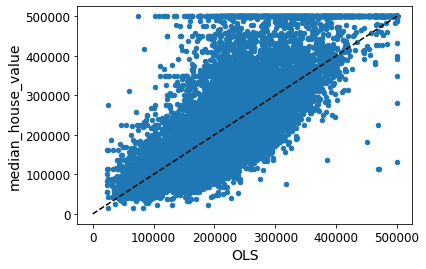

In [13]:
house_values = pd.DataFrame(Y)
house_values['OLS'] = results_OLS.fittedvalues

house_values.loc[house_values['OLS']<0.0, 'OLS']=0.0
house_values.loc[house_values['OLS']>500000.0, 'OLS']=500000.0

plt = house_values.plot.scatter(x='OLS', y='median_house_value')
plt.plot([0, 500000], [0, 500000], color = 'black', linestyle='dashed') #linewidth = 2
house_values

## OLS large

In [14]:
Y = housing2['median_house_value']

X = housing2[['median_income', 'ocean_prox', 'rooms_per_household', 'total_rooms', 'housing_median_age', 
'households', 'total_bedrooms', 'population_per_household', 'population', 'longitude', 
'latitude', 'bedrooms_per_room']]
X = sm.add_constant(X)
X

,const,median_income,ocean_prox,rooms_per_household,total_rooms,housing_median_age,households,total_bedrooms,population_per_household,population,longitude,latitude,bedrooms_per_room
14196,1.0,3.2596,1,5.017657,3126.0,33.0,623.0,627.0,3.691814,2300.0,-117.03,32.71,0.200576
8267,1.0,3.8125,1,4.473545,3382.0,49.0,756.0,787.0,1.738095,1314.0,-118.16,33.77,0.232703
17445,1.0,4.1563,1,5.645833,1897.0,4.0,336.0,331.0,2.723214,915.0,-120.48,34.66,0.174486
14265,1.0,1.9425,1,4.002817,1421.0,36.0,355.0,367.0,3.994366,1418.0,-117.11,32.69,0.258269
2271,1.0,3.5542,0,6.268421,2382.0,43.0,380.0,431.0,2.300000,874.0,-119.80,36.78,0.180940
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,1.0,6.3700,1,6.129032,1330.0,35.0,217.0,201.0,3.032258,658.0,-117.96,33.78,0.151128
11964,1.0,3.0500,0,6.868597,3084.0,33.0,449.0,570.0,3.904232,1753.0,-117.43,34.02,0.184825
5390,1.0,2.9344,1,3.986717,2101.0,36.0,527.0,569.0,3.332068,1756.0,-118.38,34.03,0.270823
860,1.0,5.7192,1,6.395349,3575.0,15.0,559.0,597.0,3.178891,1777.0,-121.96,37.58,0.166993


In [15]:
model_OLS2 = sm.OLS(Y,X)
results_OLS2 = model_OLS2.fit()
print(results_OLS2.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     2643.
Date:                Wed, 18 Oct 2023   Prob (F-statistic):               0.00
Time:                        19:01:29   Log-Likelihood:            -2.0707e+05
No. Observations:               16512   AIC:                         4.142e+05
Df Residuals:                   16499   BIC:                         4.143e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [16]:
modelfit_R2.loc['OLS2'] = [results_OLS2.rsquared, results_OLS2.rsquared_adj, results_OLS2.fvalue]
modelfit_R2

,R2,adj R2,F-stat
OLS,0.586860,0.586810,11725.424931
OLS2,0.657793,0.657545,2642.881027


In [17]:
modelfit_MSE.loc['OLS2'] = [results_OLS2.mse_model, results_OLS2.mse_resid, results_OLS2.mse_total]
modelfit_MSE

,MSE Model,MSE Resid,MSE Total
OLS,6.476849e+13,5.523765e+09,1.336859e+10
OLS2,1.209950e+13,4.578147e+09,1.336859e+10


,median_house_value,OLS,OLS2
14196,103000.0,210913.033211,179524.239971
8267,382100.0,231434.949172,287224.196380
17445,172600.0,244195.728169,242742.443470
14265,93400.0,162026.407217,144381.709123
2271,96500.0,137205.437940,162601.405038
...,...,...,...
11284,229200.0,326361.337434,310717.559276
11964,97800.0,118491.113419,116996.955845
5390,222100.0,198842.627947,197153.891511
860,283500.0,302205.680159,278811.514549


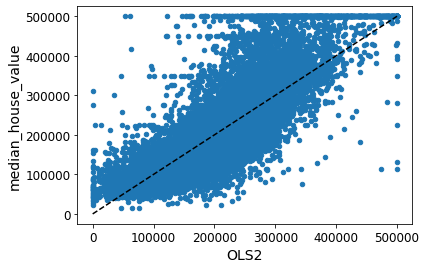

In [18]:
house_values['OLS2'] = results_OLS2.fittedvalues

house_values.loc[house_values['OLS2']<0.0, 'OLS2']=0.0
house_values.loc[house_values['OLS2']>500000.0, 'OLS2']=500000.0

plt = house_values.plot.scatter(x='OLS2', y='median_house_value')
plt.plot([0, 500000], [0, 500000], color = 'black', linestyle='dashed') #linewidth = 2
house_values

## Linearity

<AxesSubplot:ylabel='Frequency'>

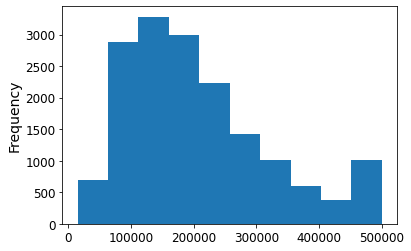

In [19]:
Y.plot.hist()

14196    11.542484
8267     12.853438
17445    12.058732
14265    11.444647
2271     11.477298
           ...    
11284    12.342350
11964    11.490680
5390     12.310883
860      12.554967
15795    12.691580
Name: median_house_value, Length: 16512, dtype: float64

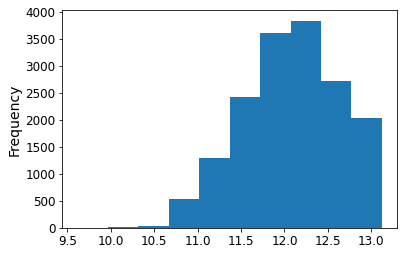

In [20]:
Y2 = np.log(Y)
Y2.plot.hist()
Y2

In [21]:
model_OLS3 = sm.OLS(Y2,X)
results_OLS3 = model_OLS3.fit()
print(results_OLS3.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     2822.
Date:                Wed, 18 Oct 2023   Prob (F-statistic):               0.00
Time:                        19:01:30   Log-Likelihood:                -4904.9
No. Observations:               16512   AIC:                             9836.
Df Residuals:                   16499   BIC:                             9936.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [22]:
modelfit_R2.loc['OLS3'] = [results_OLS3.rsquared, results_OLS3.rsquared_adj, results_OLS3.fvalue]
modelfit_R2

,R2,adj R2,F-stat
OLS,0.586860,0.586810,11725.424931
OLS2,0.657793,0.657545,2642.881027
OLS3,0.672376,0.672138,2821.715321


In [23]:
modelfit_MSE.loc['OLS3'] = [results_OLS3.mse_model, results_OLS3.mse_resid, results_OLS3.mse_total]
modelfit_MSE['Model/Total'] = modelfit_MSE['MSE Model']/modelfit_MSE['MSE Total']
modelfit_MSE

,MSE Model,MSE Resid,MSE Total,Model/Total
OLS,6.476849e+13,5.523765e+09,1.336859e+10,4844.825286
OLS2,1.209950e+13,4.578147e+09,1.336859e+10,905.068978
OLS3,2.995010e+02,1.061415e-01,3.237382e-01,925.133571


,median_house_value,OLS,OLS2,OLS3
14196,103000.0,210913.033211,179524.239971,168657.005060
8267,382100.0,231434.949172,287224.196380,258737.681974
17445,172600.0,244195.728169,242742.443470,248987.170691
14265,93400.0,162026.407217,144381.709123,140670.335820
2271,96500.0,137205.437940,162601.405038,125777.494300
...,...,...,...,...
11284,229200.0,326361.337434,310717.559276,290884.916416
11964,97800.0,118491.113419,116996.955845,108120.519026
5390,222100.0,198842.627947,197153.891511,175038.837859
860,283500.0,302205.680159,278811.514549,265053.115440


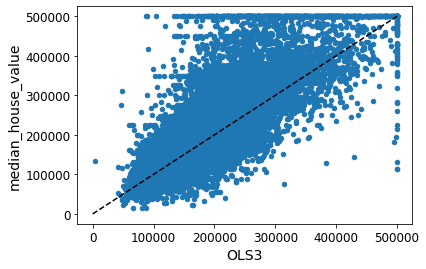

In [24]:
house_values['OLS3'] = np.exp(results_OLS3.fittedvalues)

house_values.loc[house_values['OLS3']<0.0, 'OLS3']=0.0
house_values.loc[house_values['OLS3']>500000.0, 'OLS3']=500000.0

plt = house_values.plot.scatter(x='OLS3', y='median_house_value')
plt.plot([0, 500000], [0, 500000], color = 'black', linestyle='dashed') #linewidth = 2
house_values

## Multicollinearity

In [25]:
corr = X.corr()

# sns.heatmap(corr)

# [np.max(corr[corr<1]), np.min(corr)]

In [26]:
Y = housing2['median_house_value']
Y2 = np.log(Y)

X2 = housing2[['median_income', 'ocean_prox', 'rooms_per_household', 'housing_median_age', 
'population_per_household', 'population']]  
# 'total_rooms', 'total_bedrooms', 'households', 'longitude', 'latitude', 'bedrooms_per_room'
X2 = sm.add_constant(X2)

corr = X2.corr()

# sns.heatmap(corr)

# [np.max(corr[corr<1]), np.min(corr)]

In [27]:
model_OLS4 = sm.OLS(Y2,X2)
results_OLS4 = model_OLS4.fit()
print(results_OLS4.summary())


                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     4452.
Date:                Wed, 18 Oct 2023   Prob (F-statistic):               0.00
Time:                        19:01:30   Log-Likelihood:                -6171.1
No. Observations:               16512   AIC:                         1.236e+04
Df Residuals:                   16505   BIC:                         1.241e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [28]:
modelfit_R2.loc['OLS4'] = [results_OLS4.rsquared, results_OLS4.rsquared_adj, results_OLS4.fvalue]
modelfit_R2

,R2,adj R2,F-stat
OLS,0.586860,0.586810,11725.424931
OLS2,0.657793,0.657545,2642.881027
OLS3,0.672376,0.672138,2821.715321
OLS4,0.618074,0.617935,4451.692745


In [29]:
modelfit_MSE.loc['OLS4'] = [results_OLS4.mse_model, results_OLS4.mse_resid, results_OLS4.mse_total, results_OLS4.mse_model/results_OLS4.mse_total]
modelfit_MSE

,MSE Model,MSE Resid,MSE Total,Model/Total
OLS,6.476849e+13,5.523765e+09,1.336859e+10,4844.825286
OLS2,1.209950e+13,4.578147e+09,1.336859e+10,905.068978
OLS3,2.995010e+02,1.061415e-01,3.237382e-01,925.133571
OLS4,5.506256e+02,1.236890e-01,3.237382e-01,1700.836117


,median_house_value,OLS,OLS2,OLS3,OLS4
14196,103000.0,210913.033211,179524.239971,168657.005060,191777.751618
8267,382100.0,231434.949172,287224.196380,258737.681974,216025.768018
17445,172600.0,244195.728169,242742.443470,248987.170691,205471.825798
14265,93400.0,162026.407217,144381.709123,140670.335820,152313.236491
2271,96500.0,137205.437940,162601.405038,125777.494300,121869.656839
...,...,...,...,...,...
11284,229200.0,326361.337434,310717.559276,290884.916416,320506.614172
11964,97800.0,118491.113419,116996.955845,108120.519026,110592.609717
5390,222100.0,198842.627947,197153.891511,175038.837859,180835.987256
860,283500.0,302205.680159,278811.514549,265053.115440,278029.869739


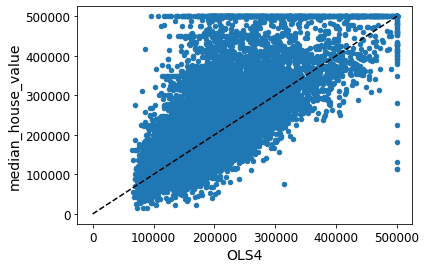

In [30]:
house_values['OLS4'] = np.exp(results_OLS4.fittedvalues)

house_values.loc[house_values['OLS4']<0.0, 'OLS4']=0.0
house_values.loc[house_values['OLS4']>500000.0, 'OLS4']=500000.0

plt = house_values.plot.scatter(x='OLS4', y='median_house_value')
plt.plot([0, 500000], [0, 500000], color = 'black', linestyle='dashed') #linewidth = 2
house_values

## Dimentionality Reduction: PCA

In [31]:
X = housing2[['median_income', 'ocean_prox', 'rooms_per_household', 'total_rooms', 'housing_median_age', 
'households', 'total_bedrooms', 'population_per_household', 'population', 'longitude', 
'latitude', 'bedrooms_per_room']]

standardisedX = scale(X)
#standardisedX = pd.DataFrame(standardisedX, index=X.index, columns=X.columns)

#pca = PCA().fit(standardisedX)
#Xpca = pd.DataFrame(pca.transform(standardisedX))
X

,median_income,ocean_prox,rooms_per_household,total_rooms,housing_median_age,households,total_bedrooms,population_per_household,population,longitude,latitude,bedrooms_per_room
14196,3.2596,1,5.017657,3126.0,33.0,623.0,627.0,3.691814,2300.0,-117.03,32.71,0.200576
8267,3.8125,1,4.473545,3382.0,49.0,756.0,787.0,1.738095,1314.0,-118.16,33.77,0.232703
17445,4.1563,1,5.645833,1897.0,4.0,336.0,331.0,2.723214,915.0,-120.48,34.66,0.174486
14265,1.9425,1,4.002817,1421.0,36.0,355.0,367.0,3.994366,1418.0,-117.11,32.69,0.258269
2271,3.5542,0,6.268421,2382.0,43.0,380.0,431.0,2.300000,874.0,-119.80,36.78,0.180940
...,...,...,...,...,...,...,...,...,...,...,...,...
11284,6.3700,1,6.129032,1330.0,35.0,217.0,201.0,3.032258,658.0,-117.96,33.78,0.151128
11964,3.0500,0,6.868597,3084.0,33.0,449.0,570.0,3.904232,1753.0,-117.43,34.02,0.184825
5390,2.9344,1,3.986717,2101.0,36.0,527.0,569.0,3.332068,1756.0,-118.38,34.03,0.270823
860,5.7192,1,6.395349,3575.0,15.0,559.0,597.0,3.178891,1777.0,-121.96,37.58,0.166993


In [32]:
X.mean()

median_income                  3.880754
ocean_prox                     0.683685
rooms_per_household            5.435235
total_rooms                 2642.004784
housing_median_age            28.608285
households                   499.986919
total_bedrooms               538.496851
population_per_household       3.096961
population                  1426.453004
longitude                   -119.582290
latitude                      35.643149
bedrooms_per_room              0.212858
dtype: float64

In [33]:
standardisedX = scale(X)
standardisedX = pd.DataFrame(standardisedX, index=X.index, columns=X.columns)
standardisedX

,median_income,ocean_prox,rooms_per_household,total_rooms,housing_median_age,households,total_bedrooms,population_per_household,population,longitude,latitude,bedrooms_per_room
14196,-0.326196,0.679433,-0.174916,0.222569,0.348490,0.322906,0.211228,0.051376,0.768276,1.272587,-1.372811,-0.211785
8267,-0.035843,0.679433,-0.402835,0.340293,1.618118,0.672027,0.593094,-0.117362,-0.098901,0.709162,-0.876696,0.342185
17445,0.144701,0.679433,0.088216,-0.342597,-1.952710,-0.430461,-0.495226,-0.032280,-0.449818,-0.447603,-0.460146,-0.661658
14265,-1.017864,0.679433,-0.600015,-0.561490,0.586545,-0.380587,-0.409306,0.077507,-0.007434,1.232698,-1.382172,0.783032
2271,-0.171488,-1.468526,0.349007,-0.119565,1.142008,-0.314962,-0.256559,-0.068832,-0.485877,-0.108551,0.532084,-0.550364
...,...,...,...,...,...,...,...,...,...,...,...,...
11284,1.307215,0.679433,0.290620,-0.603337,0.507194,-0.742833,-0.805492,-0.005588,-0.675847,0.808883,-0.872016,-1.064430
11964,-0.436266,-1.468526,0.600411,0.203255,0.348490,-0.133839,0.075188,0.069722,0.287195,1.073144,-0.759688,-0.483382
5390,-0.496973,0.679433,-0.606759,-0.248786,0.586545,0.070909,0.072801,0.020306,0.289833,0.599469,-0.755007,0.999514
860,0.965450,0.679433,0.402175,0.429046,-1.079841,0.154908,0.139628,0.007076,0.308303,-1.185540,0.906510,-0.790862


In [34]:
pca = PCA().fit(standardisedX)
Xpca = pd.DataFrame(pca.transform(standardisedX))
Xpca

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.812705,-1.546465,1.118883,-0.112114,0.095156,0.455963,-0.233653,-0.606817,0.320246,0.029336,0.022776,0.009798
1,0.472541,-1.474114,0.354825,-1.064506,-0.144891,1.145453,-0.417899,0.209496,-0.584476,0.137569,0.021145,0.082937
2,-0.385358,0.515774,0.822366,0.381051,-0.122474,-1.787313,0.703685,-0.826300,-0.041695,0.063979,-0.524697,0.004104
3,-0.698327,-2.424081,0.398520,0.119444,0.096411,0.308070,0.078158,-0.428587,0.202900,-0.073968,-0.031126,0.001892
4,-0.848122,0.849958,-0.407090,0.584533,-0.004433,1.306867,-0.936940,0.233707,-0.200757,0.000315,0.006567,0.003570
...,...,...,...,...,...,...,...,...,...,...,...,...
16507,-1.283817,0.036070,2.210447,-0.582862,0.007988,0.041026,-0.424243,0.035848,0.023757,0.108736,0.101809,-0.015398
16508,0.250145,-0.212150,0.652465,1.522603,0.174482,1.234181,-0.686063,-0.064360,0.159335,-0.066994,-0.147145,-0.108944
16509,-0.008930,-1.791239,-0.128381,-0.411589,0.034019,0.189849,0.160488,0.086928,0.196934,0.016571,0.021445,-0.036490
16510,0.664871,1.822049,0.131633,-0.782842,-0.044796,-1.081389,0.503867,-0.220206,0.163900,-0.058400,-0.005527,-0.027521


In [35]:
U, S, V = np.linalg.svd(standardisedX, full_matrices=False, compute_uv=True)
Xsvd = pd.DataFrame(U.dot(np.diag(S)))
Xsvd

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.812705,1.546465,1.118883,0.112114,0.095156,0.455963,0.233653,0.606817,0.320246,-0.029336,0.022776,0.009798
1,0.472541,1.474114,0.354825,1.064506,-0.144891,1.145453,0.417899,-0.209496,-0.584476,-0.137569,0.021145,0.082937
2,-0.385358,-0.515774,0.822366,-0.381051,-0.122474,-1.787313,-0.703685,0.826300,-0.041695,-0.063979,-0.524697,0.004104
3,-0.698327,2.424081,0.398520,-0.119444,0.096411,0.308070,-0.078158,0.428587,0.202900,0.073968,-0.031126,0.001892
4,-0.848122,-0.849958,-0.407090,-0.584533,-0.004433,1.306867,0.936940,-0.233707,-0.200757,-0.000315,0.006567,0.003570
...,...,...,...,...,...,...,...,...,...,...,...,...
16507,-1.283817,-0.036070,2.210447,0.582862,0.007988,0.041026,0.424243,-0.035848,0.023757,-0.108736,0.101809,-0.015398
16508,0.250145,0.212150,0.652465,-1.522603,0.174482,1.234181,0.686063,0.064360,0.159335,0.066994,-0.147145,-0.108944
16509,-0.008930,1.791239,-0.128381,0.411589,0.034019,0.189849,-0.160488,-0.086928,0.196934,-0.016571,0.021445,-0.036490
16510,0.664871,-1.822049,0.131633,0.782842,-0.044796,-1.081389,-0.503867,0.220206,0.163900,0.058400,-0.005527,-0.027521


In [36]:
pct_explained = pca.explained_variance_ratio_
pct_explained = pd.DataFrame(pct_explained, columns=['pct explained'])
pct_explained['cumulative'] = pct_explained.cumsum()
pct_explained.index = pct_explained.index + 1
pct_explained

,pct explained,cumulative
1,0.325471,0.325471
2,0.180813,0.506284
3,0.157131,0.663414
4,0.102906,0.766320
5,0.084194,0.850514
6,0.058090,0.908604
7,0.049760,0.958364
8,0.024129,0.982493
9,0.010968,0.993461
10,0.003405,0.996866


In [37]:
pca = PCA(whiten=True).fit(standardisedX)  # Whiten, less susceptible to outliers
Xpca = pd.DataFrame(pca.transform(standardisedX))
Xpca

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.411219,-1.049837,0.814799,-0.100887,0.094665,0.546104,-0.302362,-1.127685,0.882688,0.145137,0.139719,0.093252
1,0.239100,-1.000721,0.258392,-0.957910,-0.144144,1.371901,-0.540787,0.389320,-1.610983,0.680595,0.129709,0.789396
2,-0.194987,0.350139,0.598868,0.342894,-0.121843,-2.140652,0.910610,-1.535565,-0.114923,0.316522,-3.218666,0.039065
3,-0.353345,-1.645617,0.290212,0.107483,0.095914,0.368974,0.101141,-0.796470,0.559249,-0.365941,-0.190936,0.018012
4,-0.429140,0.577005,-0.296453,0.526000,-0.004410,1.565225,-1.212457,0.434312,-0.553345,0.001559,0.040283,0.033979
...,...,...,...,...,...,...,...,...,...,...,...,...
16507,-0.649596,0.024486,1.609703,-0.524496,0.007947,0.049136,-0.548996,0.066619,0.065480,0.537950,0.624528,-0.146557
16508,0.126570,-0.144021,0.475142,1.370134,0.173583,1.478170,-0.887806,-0.119603,0.439173,-0.331438,-0.902635,-1.036922
16509,-0.004518,-1.216005,-0.093490,-0.370374,0.033844,0.227381,0.207681,0.161544,0.542808,0.081981,0.131551,-0.347310
16510,0.336417,1.236920,0.095858,-0.704451,-0.044565,-1.295172,0.652034,-0.409223,0.451754,-0.288925,-0.033902,-0.261941


In [38]:
pct_explained = pca.explained_variance_ratio_
pct_explained = pd.DataFrame(pct_explained, columns=['pct explained'])
pct_explained['cumulative'] = pct_explained.cumsum()
pct_explained.index = pct_explained.index + 1
pct_explained

,pct explained,cumulative
1,0.325471,0.325471
2,0.180813,0.506284
3,0.157131,0.663414
4,0.102906,0.766320
5,0.084194,0.850514
6,0.058090,0.908604
7,0.049760,0.958364
8,0.024129,0.982493
9,0.010968,0.993461
10,0.003405,0.996866


In [39]:
X_PCA = pca.transform(standardisedX)
X_PCA = pd.DataFrame(X_PCA, columns=[f'PC{x+1}' for x in range(12)], index=X.index)
X_PCA

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
14196,0.411219,-1.049837,0.814799,-0.100887,0.094665,0.546104,-0.302362,-1.127685,0.882688,0.145137,0.139719,0.093252
8267,0.239100,-1.000721,0.258392,-0.957910,-0.144144,1.371901,-0.540787,0.389320,-1.610983,0.680595,0.129709,0.789396
17445,-0.194987,0.350139,0.598868,0.342894,-0.121843,-2.140652,0.910610,-1.535565,-0.114923,0.316522,-3.218666,0.039065
14265,-0.353345,-1.645617,0.290212,0.107483,0.095914,0.368974,0.101141,-0.796470,0.559249,-0.365941,-0.190936,0.018012
2271,-0.429140,0.577005,-0.296453,0.526000,-0.004410,1.565225,-1.212457,0.434312,-0.553345,0.001559,0.040283,0.033979
...,...,...,...,...,...,...,...,...,...,...,...,...
11284,-0.649596,0.024486,1.609703,-0.524496,0.007947,0.049136,-0.548996,0.066619,0.065480,0.537950,0.624528,-0.146557
11964,0.126570,-0.144021,0.475142,1.370134,0.173583,1.478170,-0.887806,-0.119603,0.439173,-0.331438,-0.902635,-1.036922
5390,-0.004518,-1.216005,-0.093490,-0.370374,0.033844,0.227381,0.207681,0.161544,0.542808,0.081981,0.131551,-0.347310
860,0.336417,1.236920,0.095858,-0.704451,-0.044565,-1.295172,0.652034,-0.409223,0.451754,-0.288925,-0.033902,-0.261941


In [40]:
X_PCA.corr()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
PC1,1.000000e+00,1.783780e-16,2.628064e-16,-3.371216e-16,-7.218702e-17,-2.970591e-16,-2.956000e-16,1.190980e-16,-1.125258e-15,-2.887373e-15,4.912658e-17,1.053715e-17
PC2,1.783780e-16,1.000000e+00,-8.050815e-16,-3.441416e-16,8.720119e-17,-4.629572e-16,-4.083991e-16,5.906419e-16,9.581902e-18,5.793117e-16,3.357880e-15,-1.626255e-15
PC3,2.628064e-16,-8.050815e-16,1.000000e+00,-1.027987e-16,-1.299440e-16,3.470464e-16,1.903369e-16,8.100708e-16,4.729761e-16,-6.768252e-16,-3.242001e-15,1.133175e-15
PC4,-3.371216e-16,-3.441416e-16,-1.027987e-16,1.000000e+00,-6.440383e-17,3.973968e-16,5.880329e-16,-7.397363e-16,3.687923e-16,-5.650431e-16,-1.594445e-15,2.819470e-15
PC5,-7.218702e-17,8.720119e-17,-1.299440e-16,-6.440383e-17,1.000000e+00,-4.504973e-16,-1.424755e-16,1.607036e-16,5.480209e-16,-1.152071e-15,-1.085462e-15,9.564837e-16
PC6,-2.970591e-16,-4.629572e-16,3.470464e-16,3.973968e-16,-4.504973e-16,1.000000e+00,5.503710e-16,-5.703148e-16,-6.624221e-16,-1.128607e-15,-9.093107e-16,-2.323738e-15
PC7,-2.956000e-16,-4.083991e-16,1.903369e-16,5.880329e-16,-1.424755e-16,5.503710e-16,1.000000e+00,4.815091e-16,7.254307e-16,1.031934e-15,3.677227e-16,-2.883720e-15
PC8,1.190980e-16,5.906419e-16,8.100708e-16,-7.397363e-16,1.607036e-16,-5.703148e-16,4.815091e-16,1.000000e+00,-1.243025e-16,1.515353e-16,-5.535481e-17,-4.341274e-18
PC9,-1.125258e-15,9.581902e-18,4.729761e-16,3.687923e-16,5.480209e-16,-6.624221e-16,7.254307e-16,-1.243025e-16,1.000000e+00,4.595009e-16,2.013780e-16,5.190014e-16
PC10,-2.887373e-15,5.793117e-16,-6.768252e-16,-5.650431e-16,-1.152071e-15,-1.128607e-15,1.031934e-15,1.515353e-16,4.595009e-16,1.000000e+00,1.160755e-16,-7.484558e-17


## PCA1: All 12 PCs

In [41]:
Y = housing2['median_house_value']
Y2 = np.log(Y)

X3 = X_PCA.copy()

X3 = sm.add_constant(X3)

model_PCA1 = sm.OLS(Y2,X3)
results_PCA1 = model_PCA1.fit()
print(results_PCA1.summary())


                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     2822.
Date:                Wed, 18 Oct 2023   Prob (F-statistic):               0.00
Time:                        19:01:30   Log-Likelihood:                -4904.9
No. Observations:               16512   AIC:                             9836.
Df Residuals:                   16499   BIC:                             9936.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0865      0.003   4767.137      0.0

In [42]:
modelfit_R2.loc['PCA1'] = [results_PCA1.rsquared, results_PCA1.rsquared_adj, results_PCA1.fvalue]
modelfit_R2

,R2,adj R2,F-stat
OLS,0.586860,0.586810,11725.424931
OLS2,0.657793,0.657545,2642.881027
OLS3,0.672376,0.672138,2821.715321
OLS4,0.618074,0.617935,4451.692745
PCA1,0.672376,0.672138,2821.715321


In [43]:
modelfit_MSE.loc['PCA1'] = [results_PCA1.mse_model, results_PCA1.mse_resid, results_PCA1.mse_total, results_PCA1.mse_model/results_PCA1.mse_total]
modelfit_MSE

,MSE Model,MSE Resid,MSE Total,Model/Total
OLS,6.476849e+13,5.523765e+09,1.336859e+10,4844.825286
OLS2,1.209950e+13,4.578147e+09,1.336859e+10,905.068978
OLS3,2.995010e+02,1.061415e-01,3.237382e-01,925.133571
OLS4,5.506256e+02,1.236890e-01,3.237382e-01,1700.836117
PCA1,2.995010e+02,1.061415e-01,3.237382e-01,925.133571


,median_house_value,OLS,OLS2,OLS3,OLS4,PCA1
14196,103000.0,210913.033211,179524.239971,168657.005060,191777.751618,168657.005060
8267,382100.0,231434.949172,287224.196380,258737.681974,216025.768018,258737.681974
17445,172600.0,244195.728169,242742.443470,248987.170691,205471.825798,248987.170691
14265,93400.0,162026.407217,144381.709123,140670.335820,152313.236491,140670.335820
2271,96500.0,137205.437940,162601.405038,125777.494300,121869.656839,125777.494300
...,...,...,...,...,...,...
11284,229200.0,326361.337434,310717.559276,290884.916416,320506.614172,290884.916416
11964,97800.0,118491.113419,116996.955845,108120.519026,110592.609717,108120.519026
5390,222100.0,198842.627947,197153.891511,175038.837859,180835.987256,175038.837859
860,283500.0,302205.680159,278811.514549,265053.115440,278029.869739,265053.115440


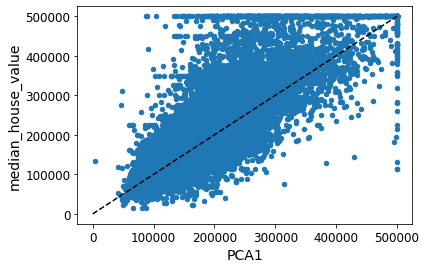

In [44]:
house_values['PCA1'] = np.exp(results_PCA1.fittedvalues)

house_values.loc[house_values['PCA1']<0.0, 'PCA1']=0.0
house_values.loc[house_values['PCA1']>500000.0, 'PCA1']=500000.0

plt = house_values.plot.scatter(x='PCA1', y='median_house_value')
plt.plot([0, 500000], [0, 500000], color = 'black', linestyle='dashed') #linewidth = 2
house_values

## PCA2: 6 PCs (Feature Reduction)

In [45]:
Y = housing2['median_house_value']
Y2 = np.log(Y)

X3 = X_PCA.copy()
print(X3.shape)

X_remove = [1, 2, 5, 7, 10, 12]
X_remove = [f'PC{x}' for x in X_remove]
print(f'Remove: {X_remove}')
X_keep = [x for x in X3.columns if x not in X_remove]
print(f'Keep: {X_keep}')

X3 = X3.loc[:,X_keep]
print(X3.shape)

X3 = sm.add_constant(X3)

model_PCA2 = sm.OLS(Y2,X3)
results_PCA2 = model_PCA2.fit()
print(results_PCA2.summary())

(16512, 12)
Remove: ['PC1', 'PC2', 'PC5', 'PC7', 'PC10', 'PC12']
Keep: ['PC3', 'PC4', 'PC6', 'PC8', 'PC9', 'PC11']
(16512, 6)
                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     4735.
Date:                Wed, 18 Oct 2023   Prob (F-statistic):               0.00
Time:                        19:01:31   Log-Likelihood:                -5852.4
No. Observations:               16512   AIC:                         1.172e+04
Df Residuals:                   16505   BIC:                         1.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----

In [46]:
modelfit_R2.loc['PCA2'] = [results_PCA2.rsquared, results_PCA2.rsquared_adj, results_PCA2.fvalue]
modelfit_R2

,R2,adj R2,F-stat
OLS,0.586860,0.586810,11725.424931
OLS2,0.657793,0.657545,2642.881027
OLS3,0.672376,0.672138,2821.715321
OLS4,0.618074,0.617935,4451.692745
PCA1,0.672376,0.672138,2821.715321
PCA2,0.632534,0.632401,4735.129463


$R^2_{PCA2} > R^2_{OLS4}$

In [47]:
modelfit_MSE.loc['PCA2'] = [results_PCA2.mse_model, results_PCA2.mse_resid, results_PCA2.mse_total, results_PCA2.mse_model/results_PCA2.mse_total]
modelfit_MSE


,MSE Model,MSE Resid,MSE Total,Model/Total
OLS,6.476849e+13,5.523765e+09,1.336859e+10,4844.825286
OLS2,1.209950e+13,4.578147e+09,1.336859e+10,905.068978
OLS3,2.995010e+02,1.061415e-01,3.237382e-01,925.133571
OLS4,5.506256e+02,1.236890e-01,3.237382e-01,1700.836117
PCA1,2.995010e+02,1.061415e-01,3.237382e-01,925.133571
PCA2,5.635082e+02,1.190059e-01,3.237382e-01,1740.629422


In [48]:
modelfit_RMSE = modelfit_MSE.copy()
modelfit_RMSE['RMSE Model'] = np.sqrt(modelfit_RMSE[['MSE Model']])
modelfit_RMSE['RMSE Resid'] = np.sqrt(modelfit_RMSE[['MSE Resid']])
modelfit_RMSE['RMSE Total'] = np.sqrt(modelfit_RMSE[['MSE Total']])
modelfit_RMSE['Model/Total'] = modelfit_RMSE['RMSE Model'] / modelfit_RMSE['RMSE Total']
modelfit_RMSE = modelfit_RMSE.loc[:, ['RMSE Model', 'RMSE Resid', 'RMSE Total', 'Model/Total']]
modelfit_RMSE

,RMSE Model,RMSE Resid,RMSE Total,Model/Total
OLS,8.047887e+06,74322.035469,115622.626448,69.604779
OLS2,3.478433e+06,67662.005105,115622.626448,30.084364
OLS3,1.730610e+01,0.325794,0.568980,30.416008
OLS4,2.346541e+01,0.351695,0.568980,41.241194
PCA1,1.730610e+01,0.325794,0.568980,30.416008
PCA2,2.373833e+01,0.344972,0.568980,41.720851


,median_house_value,OLS,OLS2,OLS3,OLS4,PCA1,PCA2
14196,103000.0,210913.033211,179524.239971,168657.005060,191777.751618,168657.005060,178676.048814
8267,382100.0,231434.949172,287224.196380,258737.681974,216025.768018,258737.681974,271854.403472
17445,172600.0,244195.728169,242742.443470,248987.170691,205471.825798,248987.170691,229602.278967
14265,93400.0,162026.407217,144381.709123,140670.335820,152313.236491,140670.335820,160112.483186
2271,96500.0,137205.437940,162601.405038,125777.494300,121869.656839,125777.494300,134295.627241
...,...,...,...,...,...,...,...
11284,229200.0,326361.337434,310717.559276,290884.916416,320506.614172,290884.916416,308199.345191
11964,97800.0,118491.113419,116996.955845,108120.519026,110592.609717,108120.519026,117797.951660
5390,222100.0,198842.627947,197153.891511,175038.837859,180835.987256,175038.837859,186995.019432
860,283500.0,302205.680159,278811.514549,265053.115440,278029.869739,265053.115440,233315.160725


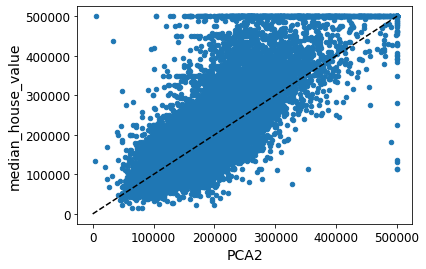

In [49]:
house_values['PCA2'] = np.exp(results_PCA2.fittedvalues)

house_values.loc[house_values['PCA2']<0.0, 'PCA2']=0.0
house_values.loc[house_values['PCA2']>500000.0, 'PCA2']=500000.0

plt = house_values.plot.scatter(x='PCA2', y='median_house_value')
plt.plot([0, 500000], [0, 500000], color = 'black', linestyle='dashed') #linewidth = 2
house_values

# Regularization

## A Horse Race

In [50]:
def horse_race(train, labels):
    results={}
    def test_model(clf):
        
        cv = KFold(n_splits=5,shuffle=True,random_state=45)
        r2 = make_scorer(r2_score)
        r2_val_score = cross_val_score(clf, train, labels, cv=cv,scoring=r2)
        scores=[r2_val_score.mean()]
        return scores

    clf = linear_model.LinearRegression()
    results["Linear"]=test_model(clf)
    
    clf = linear_model.Ridge()
    results["Ridge"]=test_model(clf)
    
    clf = linear_model.Lasso(alpha=1e-4)
    results["Lasso"]=test_model(clf)
    
    results = pd.DataFrame.from_dict(results,orient='index')
    results.columns=["R Square Score"] 
    #print(results)
    results=results.sort_values(by=["R Square Score"], ascending=False)
    results.plot(kind="bar",title="Model Scores", ylim=(0,1))
    return results


In [51]:
X = housing2[['median_income', 'ocean_prox', 'rooms_per_household', 'total_rooms', 'housing_median_age', 
'households', 'total_bedrooms', 'population_per_household', 'population', 'longitude', 
'latitude', 'bedrooms_per_room']]
standardisedX = scale(X)
standardisedX

array([[-0.326196  ,  0.67943253, -0.17491646, ...,  1.27258656,
        -1.3728112 , -0.2117846 ],
       [-0.03584338,  0.67943253, -0.40283542, ...,  0.70916212,
        -0.87669601,  0.34218528],
       [ 0.14470145,  0.67943253,  0.08821601, ..., -0.44760309,
        -0.46014647, -0.66165785],
       ...,
       [-0.49697313,  0.67943253, -0.60675918, ...,  0.59946887,
        -0.75500738,  0.99951387],
       [ 0.96545045,  0.67943253,  0.40217517, ..., -1.18553953,
         0.90651045, -0.79086209],
       [-0.68544764,  0.67943253, -0.85144571, ..., -1.41489815,
         0.99543676,  1.69520292]])

In [52]:
Y = housing2['median_house_value']
Y2 = np.log(Y)
Y2.values

array([11.54248427, 12.85343763, 12.05873206, ..., 12.31088301,
       12.5549674 , 12.69158046])

,R Square Score
Lasso,0.670618
Ridge,0.670527
Linear,0.670520


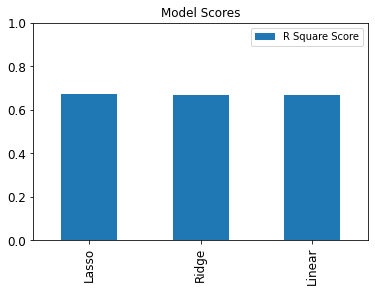

In [53]:
results_all = horse_race(standardisedX, Y2.values)
results_all

In [54]:
lin = linear_model.LinearRegression()  # random_state=0
results_lin = lin.fit(standardisedX, Y2.values)
predictions_lin = lin.predict(standardisedX)
mse_lin = mean_squared_error(Y2.values, predictions_lin)

ridge = linear_model.Ridge()  # random_state=0
results_ridge = ridge.fit(standardisedX, Y2.values)
predictions_ridge = ridge.predict(standardisedX)
mse_ridge = mean_squared_error(Y2.values, predictions_ridge)

lasso = linear_model.Lasso(alpha=1e-4)  # random_state=0
results_lasso = lasso.fit(standardisedX, Y2.values)
predictions_lasso = lasso.predict(standardisedX)
mse_lasso = mean_squared_error(Y2.values, predictions_lasso)

print(f"MSE:")
print(f"OLS: {mse_lin}, Ridge: {mse_ridge}, Lasso: {mse_lasso}")
print(f"Ridge/OLS: {mse_ridge/mse_lin}, Lasso/OLS: {mse_lasso/mse_lin}")


MSE:
OLS: 0.10605791447081665, Ridge: 0.1060579492849431, Lasso: 0.10605878980569533
Ridge/OLS: 1.0000003282558083, Lasso/OLS: 1.0000082533668802


## The distribution of MSE via cross-validation

In [55]:
score_lin = -cross_val_score(
            lin, standardisedX, Y2.values, 
            scoring="neg_mean_squared_error", # for some reason cross_val_score computes negative of MSE
            cv=10)

score_ridge = -cross_val_score(
            ridge, standardisedX, Y2.values, 
            scoring="neg_mean_squared_error", # for some reason cross_val_score computes negative of MSE
            cv=10)

score_lasso = -cross_val_score(
            lasso, standardisedX, Y2.values, 
            scoring="neg_mean_squared_error", # for some reason cross_val_score computes negative of MSE
            cv=10)

Remember the Bias-Variance tradeoff:

\begin{align}
E[(y-\hat{y})^2] = & (E[\hat{y}]-E[y])^2 + E[(\hat{y}-E[\hat{y}] )^2]+\sigma^2 \\
= & Bias + Variance + error
\end{align}

The MSE variance can therefore come from both bias and from variance of the estimator

In [56]:
print(f"Variance Ratio:")
print(f"Ridge/OLS: {score_ridge.std()/score_lin.std()}")
print(f"Lasso/OLS: {score_lasso.std()/score_lin.std()}")

Variance Ratio:
Ridge/OLS: 0.9988372765961875
Lasso/OLS: 0.9955594027364527


## Horse Race 2

In [57]:
def horse_race_2(train, labels):
    results={}
    def test_model(clf):
        cv = KFold(n_splits=5,shuffle=True,random_state=45)
        r2 = make_scorer(r2_score)
        r2_val_score = cross_val_score(clf, train, labels, cv=cv,scoring=r2)
        scores=[r2_val_score.mean()]
        return scores

    clf = linear_model.LinearRegression()
    results["Linear"]=test_model(clf)
    
    clf = linear_model.Ridge()
    results["Ridge"]=test_model(clf)
    
    clf = linear_model.Lasso(alpha=1e-4)
    results["Lasso"]=test_model(clf)
    
    clf = linear_model.BayesianRidge()
    results["Bayesian Ridge"]=test_model(clf)
    
    clf = linear_model.HuberRegressor()
    results["Hubber"]=test_model(clf)
    
    clf = BaggingRegressor()
    results["Bagging"]=test_model(clf)
    
    clf = RandomForestRegressor()
    results["RandomForest"]=test_model(clf)
    
    clf = AdaBoostRegressor()
    results["AdaBoost"]=test_model(clf)
    
    clf = svm.SVR()
    results["SVM RBF"]=test_model(clf)
    
    clf = svm.SVR(kernel="linear")
    results["SVM Linear"]=test_model(clf)
    
    results = pd.DataFrame.from_dict(results,orient='index')
    results.columns=["R Square Score"] 
    #print(results)
    results=results.sort_values(by=["R Square Score"], ascending=False)
    results.plot(kind="bar",title="Model Scores")
    return results


In [58]:
results_all = horse_race_2(standardisedX, Y2.values)
results_all

KeyboardInterrupt: 

In [ ]:
X3 = X_PCA.copy()
results_all_PCA = horse_race_2(X3, Y2.values)
results_all_PCA

In [ ]:
RF = RandomForestRegressor()  # max_depth=2, random_state=0
results_RF = RF.fit(standardisedX, Y2.values)

In [ ]:
predictions = RF.predict(standardisedX)
errors = abs(predictions - Y2.values)
print('Mean Absolute Error:', round(np.mean(errors), 4))

In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / Y2.values)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print(f'Accuracy: {round(accuracy, 2)}%')

In [ ]:
# Get numerical feature importances
importances = list(RF.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('{:30} Importance: {}'.format(*pair)) for pair in feature_importances];

In [ ]:
house_values['RF'] = np.exp(predictions)

house_values.loc[house_values['RF']<0.0, 'RF']=0.0
house_values.loc[house_values['RF']>500000.0, 'RF']=500000.0

plt = house_values.plot.scatter(x='RF', y='median_house_value')
plt.plot([0, 500000], [0, 500000], color = 'black', linestyle='dashed') #linewidth = 2
house_values